In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
path="/content/drive/MyDrive/Research/cods_comad_plots/SDC/dataset_3/"

In [59]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [60]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [61]:
x = np.zeros((5000,2))

In [62]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [63]:
x[idx[0]][0], x[idx[5]][5] 

(array([5.14957125, 4.78451422]), array([0.87756167, 0.00457805]))

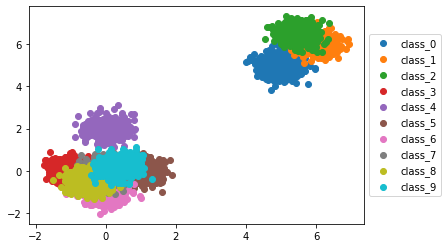

In [64]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [65]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [66]:
np.unique(bg_idx).shape

(3513,)

In [67]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [68]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-1.04275003e-16,  6.74571889e-17]]),
 array([[1.63261967, 1.69552644]]))

In [69]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [70]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[3.93071885, 3.03840862]]))

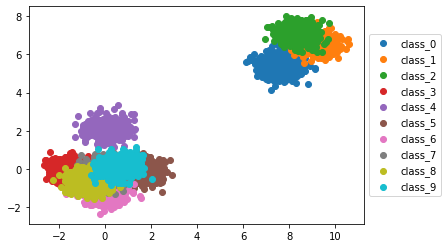

In [71]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [72]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [73]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,9)

a = []
for i in range(9):
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(3,10)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 6 present at 1
foreground 2 present at 2
background 5 present at 3
background 3 present at 4
background 5 present at 5
background 7 present at 6
background 6 present at 7
background 5 present at 8
(9, 2)
2 2


In [74]:
a.shape

(9, 2)

In [75]:
np.reshape(a,(18,1)) #not required

array([[ 1.52560273],
       [-0.1298488 ],
       [-0.4226508 ],
       [-1.2003313 ],
       [ 8.5153438 ],
       [ 7.02349438],
       [ 2.09728368],
       [-0.24465132],
       [-0.98608769],
       [-0.75123246],
       [ 1.37297554],
       [-0.37673308],
       [-0.88469208],
       [-0.11155199],
       [ 0.32308641],
       [-1.23774128],
       [ 1.37297554],
       [-0.37673308]])

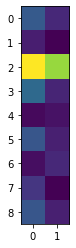

In [76]:
a=np.reshape(a,(9,2))

plt.imshow(a)

In [77]:
desired_num = 2000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,9)
    a = []
    for i in range(9):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(a)
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [78]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [79]:
len(mosaic_list_of_images), mosaic_list_of_images[0]

(2000, array([[-1.62022144,  0.11407722],
        [ 0.50044544,  1.71315143],
        [-0.72603666, -0.68240088],
        [ 0.34070696,  0.0288995 ],
        [ 0.71631136, -0.14262169],
        [ 8.2380912 ,  5.87796794],
        [ 1.24086849, -0.14745404],
        [ 0.70237352,  0.29618561],
        [ 0.22554429,  0.19892312]]))

In [80]:
mosaic_list_of_images_reshaped = np.reshape(mosaic_list_of_images, (2000,9,2))
mean_train = np.mean(mosaic_list_of_images_reshaped[0:1000], axis=0, keepdims= True)
print(mean_train.shape, mean_train)
std_train = np.std(mosaic_list_of_images_reshaped[0:1000], axis=0, keepdims= True)
print(std_train.shape, std_train)



(1, 9, 2) [[[1.04701735 0.79026777]
  [0.99547395 0.83600726]
  [0.97749982 0.73679887]
  [1.00822732 0.77856176]
  [0.90516311 0.66827389]
  [0.91422466 0.67599088]
  [0.98464597 0.71921967]
  [0.92614737 0.71352293]
  [0.92165627 0.69056608]]]
(1, 9, 2) [[[2.85278682 2.24907562]
  [2.85326479 2.25621769]
  [2.84794039 2.26546119]
  [2.8808435  2.2856376 ]
  [2.73527328 2.15939348]
  [2.77350541 2.20945159]
  [2.78075744 2.1967366 ]
  [2.76777997 2.25477549]
  [2.70067785 2.16831973]]]


In [81]:
mosaic_list_of_images = ( mosaic_list_of_images_reshaped - mean_train ) / std_train

In [82]:
print(np.mean(mosaic_list_of_images[0:1000], axis=0, keepdims= True))

print(np.std(mosaic_list_of_images[0:1000], axis=0, keepdims= True))

[[[-2.73336909e-16 -5.42899059e-17]
  [-8.75965966e-17 -4.74731365e-16]
  [-2.23099317e-16 -4.38538095e-16]
  [ 2.81996648e-16  3.13804538e-16]
  [ 1.55875313e-16 -2.43360887e-16]
  [ 2.44249065e-16  3.76143561e-16]
  [ 2.61318744e-17  6.72129019e-16]
  [ 2.93209901e-16  2.67619260e-16]
  [ 1.47132306e-16 -3.11972670e-17]]]
[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]


In [83]:
print(np.mean(mosaic_list_of_images[1000:2000], axis=0, keepdims= True))

print(np.std(mosaic_list_of_images[1000:2000], axis=0, keepdims= True))

[[[-0.02016807 -0.02119273]
  [ 0.01601034 -0.01376   ]
  [-0.00274628  0.00311453]
  [ 0.00413155 -0.00944241]
  [-0.0502883  -0.03638878]
  [-0.00938825  0.01935467]
  [-0.00108587  0.00761862]
  [-0.03241195 -0.05409312]
  [-0.03516761 -0.01676287]]]
[[[0.98740625 0.99103505]
  [1.03274344 1.01777537]
  [0.9960355  0.99079995]
  [0.99570229 0.99596594]
  [0.96262172 0.97223987]
  [1.01993176 1.00476581]
  [1.03373143 1.02810669]
  [0.97171713 0.93887409]
  [1.00935444 0.99404134]]]


In [84]:
mosaic_list_of_images.shape

(2000, 9, 2)

In [85]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [86]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:1000], mosaic_label[0:1000] , fore_idx[0:1000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [87]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[1000:2000], mosaic_label[1000:2000] , fore_idx[1000:2000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [88]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()

    self.fc1 = nn.Linear(2, 1, bias=False)
    torch.nn.init.zeros_(self.fc1.weight)
    # self.fc2 = nn.Linear(50, 10)
    # self.fc3 = nn.Linear(10, 1)

  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,2], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = y.to("cuda")
    x = x.to("cuda")
    # print(x.shape, z.shape)
    for i in range(9):
      # print(z[:,i].shape)
      # print(self.helper(z[:,i])[:,0].shape)
      x[:,i] = self.helper(z[:,i])[:,0]
    # print(x.shape, z.shape)
    x = F.softmax(x,dim=1)
    # print(x.shape, z.shape)
    # x1 = x[:,0]
    # print(torch.mul(x[:,0],z[:,0]).shape)

    for i in range(9):            
      # x1 = x[:,i]          
      y = y + torch.mul(x[:,i,None],z[:,i])

    # print(x.shape, y.shape)
    return x, y
    
  def helper(self, x):
    x = x.view(-1, 2)
    # x = F.relu(self.fc1(x))
    # x = F.relu(self.fc2(x))
    x = (self.fc1(x))

    return x

In [89]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 50)
    self.fc2 = nn.Linear(50, 10)
    self.fc3 = nn.Linear(10, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.zeros_(self.fc3.bias)


  def forward(self, x):
    x = x.view(-1, 2)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = (self.fc3(x))
    return x

In [90]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [91]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to("cuda")

In [92]:
focus_net.helper( torch.randn((1,9,2)).double().to("cuda") )

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', dtype=torch.float64, grad_fn=<MmBackward>)

In [93]:
focus_net.fc1.weight

Parameter containing:
tensor([[0., 0.]], device='cuda:0', dtype=torch.float64, requires_grad=True)

In [94]:
classify.fc1.weight, classify.fc1.bias, classify.fc1.weight.shape

(Parameter containing:
 tensor([[-0.0613,  0.2164],
         [-0.0953,  0.1494],
         [-0.1151, -0.0352],
         [ 0.0861,  0.1468],
         [ 0.1764,  0.0064],
         [ 0.3295, -0.0229],
         [ 0.1412,  0.0129],
         [ 0.0870, -0.1923],
         [ 0.1262, -0.0090],
         [ 0.0823, -0.0520],
         [-0.2655,  0.1826],
         [-0.0446,  0.0966],
         [ 0.0981, -0.3714],
         [ 0.0571,  0.3428],
         [ 0.0068,  0.0859],
         [ 0.1727,  0.0149],
         [-0.2057, -0.0820],
         [ 0.0142, -0.1318],
         [ 0.2629,  0.0146],
         [-0.0523, -0.2022],
         [-0.0810,  0.1783],
         [ 0.0920,  0.1911],
         [ 0.3542,  0.0953],
         [ 0.4159, -0.2334],
         [ 0.0363,  0.0841],
         [-0.1354, -0.0821],
         [ 0.3490, -0.2147],
         [-0.0150, -0.1926],
         [ 0.1216, -0.2883],
         [ 0.1449, -0.2849],
         [-0.1218,  0.1974],
         [-0.0958,  0.1638],
         [-0.1725, -0.1064],
         [-0.0082, -

In [95]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_classify = optim.Adam(classify.parameters(), lr=0.01 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

In [96]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [97]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)
    # print(predicted.shape)

    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      # print(focus, fore_idx[j], predicted[j])
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)

Accuracy of the network on the 1000 train images: 37 %
total correct 377
total train set images 1000
focus_true_pred_true 43 =============> FTPT : 4 %
focus_false_pred_true 334 =============> FFPT : 33 %
focus_true_pred_false 77 =============> FTPF : 7 %
focus_false_pred_false 546 =============> FFPF : 54 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000
1000


In [98]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)

Accuracy of the network on the 1000 test images: 34 %
total correct 342
total train set images 1000
focus_true_pred_true 37 =============> FTPT : 3 %
focus_false_pred_true 305 =============> FFPT : 30 %
focus_true_pred_false 79 =============> FTPF : 7 %
focus_false_pred_false 579 =============> FFPF : 57 %
argmax_more_than_half ==================>  0
argmax_less_than_half ==================>  1000


In [99]:
nos_epochs = 1000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 3
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    if epoch % 5 == 0:
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

  if(np.mean(epoch_loss) <= 0.001):
      break;

  if epoch % 5 == 0:
    col1.append(epoch + 1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    # print("="*20)
    # print("Train FTPT : ", col4)
    # print("Train FFPT : ", col5)
    #************************************************************************
    #testing data set  
    # focus_net.eval()
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images = focus_net(inputs)
        outputs = classify(avg_images)
        _, predicted = torch.max(outputs.data, 1)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    # print("Test FTPT : ", col10)
    # print("Test FFPT : ", col11)
    # print("="*20)
    
print('Finished Training')

[1,     3] loss: 1.092
[2,     3] loss: 1.062
[3,     3] loss: 1.024
[4,     3] loss: 0.960
[5,     3] loss: 0.873
[6,     3] loss: 0.760
[7,     3] loss: 0.667
[8,     3] loss: 0.609
[9,     3] loss: 0.543
[10,     3] loss: 0.492
[11,     3] loss: 0.467
[12,     3] loss: 0.453
[13,     3] loss: 0.413
[14,     3] loss: 0.397
[15,     3] loss: 0.376
[16,     3] loss: 0.377
[17,     3] loss: 0.353
[18,     3] loss: 0.342
[19,     3] loss: 0.333
[20,     3] loss: 0.329
[21,     3] loss: 0.302
[22,     3] loss: 0.314
[23,     3] loss: 0.288
[24,     3] loss: 0.303
[25,     3] loss: 0.311
[26,     3] loss: 0.335
[27,     3] loss: 0.300
[28,     3] loss: 0.303
[29,     3] loss: 0.290
[30,     3] loss: 0.293
[31,     3] loss: 0.281
[32,     3] loss: 0.260
[33,     3] loss: 0.289
[34,     3] loss: 0.274
[35,     3] loss: 0.304
[36,     3] loss: 0.263
[37,     3] loss: 0.287
[38,     3] loss: 0.269
[39,     3] loss: 0.266
[40,     3] loss: 0.279
[41,     3] loss: 0.269
[42,     3] loss: 0.256
[

In [100]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [101]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]

In [102]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [103]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1000,43,334,77,546
1,1,0,1000,335,86,445,134
2,6,0,1000,685,0,315,0
3,11,0,1000,784,0,216,0
4,16,526,474,842,0,158,0
...,...,...,...,...,...,...,...
196,976,1000,0,896,0,104,0
197,981,1000,0,906,0,94,0
198,986,1000,0,900,0,100,0
199,991,1000,0,901,0,99,0


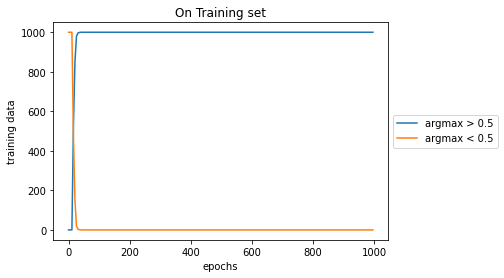

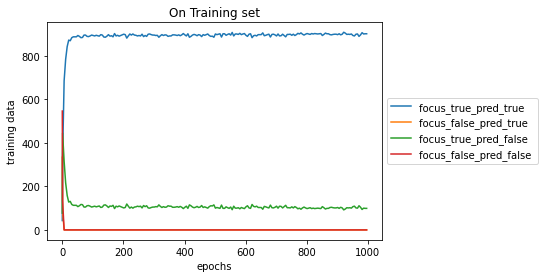

In [104]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.show()

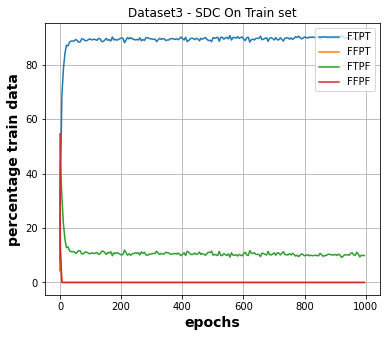

In [105]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/10, label ="FTPT")
plt.plot(col1,np.array(col5)/10, label ="FFPT")
plt.plot(col1,np.array(col6)/10, label ="FTPF")
plt.plot(col1,np.array(col7)/10, label ="FFPF")
plt.title("Dataset3 - SDC On Train set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper right')
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"ds3_train.png", bbox_inches="tight")
plt.savefig(path+"ds3_train.pdf", bbox_inches="tight")
plt.savefig("ds3_train.png", bbox_inches="tight")
plt.savefig("ds3_train.pdf", bbox_inches="tight")
plt.show()

In [106]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,0,0,1000,37,305,79,579
1,1,0,1000,440,0,560,0
2,6,0,1000,710,0,290,0
3,11,2,998,797,0,203,0
4,16,568,432,840,0,160,0
...,...,...,...,...,...,...,...
196,976,1000,0,886,0,114,0
197,981,1000,0,885,0,115,0
198,986,1000,0,887,0,113,0
199,991,1000,0,894,0,106,0


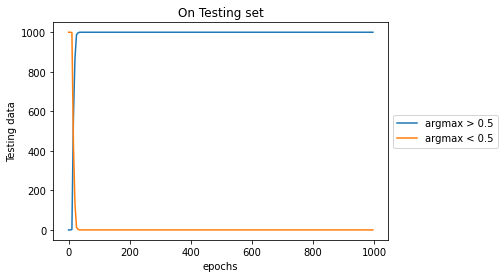

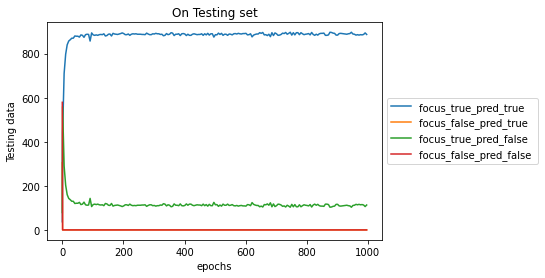

In [107]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.show()

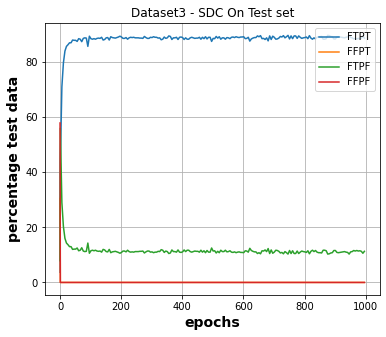

In [108]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/10, label ="FTPT")
plt.plot(col1,np.array(col11)/10, label ="FFPT")
plt.plot(col1,np.array(col12)/10, label ="FTPF")
plt.plot(col1,np.array(col13)/10, label ="FFPF")
plt.title("Dataset3 - SDC On Test set")
plt.grid()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='upper right')
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
plt.savefig(path+"ds3_test.png", bbox_inches="tight")
plt.savefig(path+"ds3_test.pdf", bbox_inches="tight")
plt.savefig("ds3_test.png", bbox_inches="tight")
plt.savefig("ds3_test.pdf", bbox_inches="tight")
plt.show()

In [109]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 1000 train images: 89 %
total correct 892
total train set images 1000
focus_true_pred_true 892 =============> FTPT : 89 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 108 =============> FTPF : 10 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  1000
argmax_less_than_half ==================>  0


In [110]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %d %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %d %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %d %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %d %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 1000 test images: 87 %
total correct 879
total train set images 1000
focus_true_pred_true 879 =============> FTPT : 87 %
focus_false_pred_true 0 =============> FFPT : 0 %
focus_true_pred_false 121 =============> FTPF : 12 %
focus_false_pred_false 0 =============> FFPF : 0 %
argmax_more_than_half ==================>  1000
argmax_less_than_half ==================>  0


In [111]:
correct = 0
total = 0

with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 train images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 1000 train images: 89 %
total correct 892
total train set images 1000


In [112]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 1000 test images: %d %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 1000 test images: 87 %
total correct 879
total train set images 1000
